In [ ]:
import os
from collections import defaultdict

import contextily as cx  # type: ignore
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from routingpy import ORS  # type: ignore
from shapely.geometry import Point, Polygon

"""
Поиск оптимальной точки встречи для трёх людей или более,
которые двигаются на любом виде транспорта по графу
и имеют конечную точку назначения.
Точки-прекандидаты располагаются в полигоне, охватывающем всех людей.
Точки-кандидаты располагаются около наилучшей точки из точек прекандидатов.
"""

# TODO:
# Сейчас даже точки кандидатов могу находиться очень далеко друг от друга
# Нужно либо прекандидатов привязать к графу, чтобы они не лежали в промках и уменьшить область поиска для кандидатов
# Либо отбирать кандидатов не рандомные точки, а POI в зависомости от сценария.
# А лучше и то и другое, особенно если первый шаг не затратный по времени.
# Второй шаг в OSM можно сделать как отобрать POI по количеству заполненных атрибутов.

ORS_API_KEY = os.getenv("ORS_API_KEY")
SERVICE_MATRIX_LIMIT = 3500
client = ORS(
    api_key=ORS_API_KEY,
    timeout=10,
    retry_timeout=60,
    retry_over_query_limit=True,
    skip_api_error=True,
)


def create_base_search_area(points):
    """Создаёт расширенный прямоугольный полигон вокруг заданных точек."""
    gdf = gpd.GeoDataFrame(
        geometry=[Polygon([(p.x, p.y) for p in points])], crs="EPSG:4326"
    )
    crs_utm = gdf.estimate_utm_crs()
    gdf = gdf.to_crs(crs_utm)
    gdf = gdf.buffer(1000)
    return gpd.GeoDataFrame(geometry=gdf.envelope, crs=crs_utm)


def create_local_search_area(point, x_step, y_step):
    """Создаёт прямоугольный полигон вокруг заданной точки."""
    gdf = gpd.GeoDataFrame(geometry=[Point(point)], crs="EPSG:4326")
    crs_utm = gdf.estimate_utm_crs()
    gdf = gdf.to_crs(crs_utm)
    buffer_radius = np.ceil(max(x_step, y_step) * 2)
    gdf_buffer = gpd.GeoDataFrame(geometry=gdf.buffer(buffer_radius), crs=crs_utm)
    return gpd.GeoDataFrame(geometry=gdf_buffer.envelope, crs=crs_utm)


def generate_candidates(search_area, people_points):
    """Генерация сетки точек-кандидатов в пределах полигона
    с учётом ограничений на максимальное количество элементов
    в возвращаемой матрице."""
    minx, miny, maxx, maxy = search_area.iloc[0].geometry.bounds
    width = maxx - minx
    height = maxy - miny

    max_points = SERVICE_MATRIX_LIMIT / len(people_points)
    approx_step = np.sqrt(1 / max_points)
    approx_step = np.clip(approx_step, 0.01, 0.2)
    x_step = width * approx_step
    y_step = height * approx_step

    x_coords = np.arange(minx, maxx, x_step)
    y_coords = np.arange(miny, maxy, y_step)

    candidates = [
        Point(float(x), float(y))
        for x in x_coords
        for y in y_coords
        if search_area.iloc[0].geometry.contains(Point(float(x), float(y)))
    ]

    gdf_candidates = gpd.GeoDataFrame(geometry=candidates, crs=search_area.crs).to_crs(
        "EPSG:4326"
    )
    return list(gdf_candidates.geometry.values), (x_step, y_step)


def build_matrix(client, sources, targets, profiles):
    """Группированный вызов ORS Matrix API по профилямпередвижения."""
    # Группируем индексы людей по профилям
    profile_groups = defaultdict(list)
    for i, p in enumerate(profiles):
        profile_groups[p].append(i)

    num_people = len(sources)
    num_targets = len(targets)
    durations = np.full((num_people, num_targets), np.inf, dtype=float)

    # Для каждой группы (один тип транспорта — один запрос)
    for profile, idxs in profile_groups.items():
        group_sources = [sources[i] for i in idxs]
        start_points = [[p.x, p.y] for p in group_sources]
        target_points = [[p.x, p.y] for p in targets]

        # Один API-запрос для этой группы
        result = client.matrix(
            locations=start_points + target_points,
            profile=profile,
            sources=list(range(len(start_points))),
            destinations=list(
                range(len(start_points), len(start_points) + len(target_points))
            ),
            metrics=["duration"],
        )

        # Добавляем данные в общую матрицу
        for row_i, person_i in enumerate(idxs):
            durations[person_i, :] = result.durations[row_i]

    return durations


def build_main_vector(client, candidates, dest, profile):
    """
    Матрица времени от кандидатов до пункта назначения.
    Отличие от основного вызова лишь в формате ответа:
    однномерный массив на который можно перемножить (использовать как вектор).
    Можно было бы интегрировать в build_matrix для минимизации запросов, но так
    функцию проще добавлять отдельно в зависимости от типа встречи: встреча или поездка.
    """
    start_points = [[p.x, p.y] for p in candidates]
    target_points = [[dest.x, dest.y]]
    result = client.matrix(
        locations=start_points + target_points,
        profile=profile,
        sources=list(range(len(start_points))),
        destinations=[len(start_points)],
        metrics=["duration"],
    )
    return np.array([r[0] for r in result.durations], dtype=float)


def find_optimal_meetpoint(
    matrix_people_to_meetpoint, vector_meetpoint_to_dest, candidates, type_of_meetpoint
):
    """Находит оптимальную точку встречи в зависимости от критерия и наличия конечной точки."""
    people_count = matrix_people_to_meetpoint.shape[0]
    if vector_meetpoint_to_dest is None:
        if type_of_meetpoint == "minisum":
            sum_obj = np.sum(matrix_people_to_meetpoint, axis=0)
            sum_obj = np.where(np.isnan(sum_obj), np.inf, sum_obj)
            j_sum = np.argmin(sum_obj)
            return candidates[j_sum]
        elif type_of_meetpoint == "minimax":
            max_obj = np.max(matrix_people_to_meetpoint, axis=0)
            max_obj = np.where(np.isnan(max_obj), np.inf, max_obj)
            j_max = np.argmin(max_obj)
            return candidates[j_max]
        else:
            raise ValueError("type_of_meetpoint должен быть 'minisum' или 'minimax'")

    if type_of_meetpoint == "minisum":
        sum_persons = np.sum(matrix_people_to_meetpoint, axis=0)
        sum_obj = sum_persons + people_count * vector_meetpoint_to_dest
        sum_obj = np.where(np.isnan(sum_obj), np.inf, sum_obj)
        j_sum = np.argmin(sum_obj)
        return candidates[j_sum]
    elif type_of_meetpoint == "minimax":
        max_arr = np.max(matrix_people_to_meetpoint, axis=0)
        max_obj = max_arr + vector_meetpoint_to_dest
        max_obj = np.where(np.isnan(max_obj), np.inf, max_obj)
        j_max = np.argmin(max_obj)
        return candidates[j_max]
    else:
        raise ValueError("type_of_meetpoint должен быть 'minisum' или 'minimax'")


def visualize_map(people_points, people_profiles, best_meetpoint, dest_point=None):
    """
    Визуализирует участников, их профили, оптимальную точку встречи
    и (опционально) конечный пункт назначения на карте.
    """
    roles = [chr(65 + i) for i in range(len(people_points))] + ["MeetPoint"]
    profiles = people_profiles + [""]

    geometries = [p for p in people_points] + [best_meetpoint]

    if dest_point is not None:
        roles.append("Destination")
        profiles.append("")
        geometries.append(dest_point)

    gdf = gpd.GeoDataFrame(
        {"role": roles, "profile": profiles},
        geometry=geometries,
        crs="EPSG:4326",
    )

    gdf_web = gdf.to_crs("EPSG:3857")

    fig, ax = plt.subplots(figsize=(10, 10))
    xmin, ymin, xmax, ymax = gdf_web.total_bounds
    xrange = float(xmax - xmin)
    yrange = float(ymax - ymin)
    buffer = max(xrange, yrange) * 0.2
    max_range = max(xrange, yrange) + buffer
    xmid = (xmin + xmax) / 2
    ymid = (ymin + ymax) / 2
    xmin, xmax = xmid - max_range / 2, xmid + max_range / 2
    ymin, ymax = ymid - max_range / 2, ymid + max_range / 2
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    cx.add_basemap(ax, crs=gdf_web.crs, source=cx.providers.CartoDB.Positron)

    color_map = {"MeetPoint": "red", "Destination": "green"}
    gdf_web.plot(
        ax=ax,
        color=gdf_web["role"].map(color_map).fillna("blue"),
        markersize=80,
    )

    for x, y, label, prof in zip(
        gdf_web.geometry.x, gdf_web.geometry.y, gdf_web["role"], gdf_web["profile"]
    ):
        ax.text(
            float(x),
            float(y),
            f"{label} ({prof})" if prof else label,
            fontsize=11,
            va="bottom",
            color="black",
            fontweight="bold" if label in ["MeetPoint", "Destination"] else "normal",
        )

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Блок 1: Выбор режима поиска точки встречи и наличия конечной точки
    type_of_meetpoint = "minimax"  # ["minimax", "minisum"]

    dest_point = Point(38.765574, 55.095276)  # None or Point(lon, lat)
    dest_profile = "driving-car"

    # Блок 2: Определение местоположения людей, их транспорта передвижения и пункта назначения
    people_points = [
        Point(37.802357, 55.668757),
        Point(37.527237, 55.644621),
        Point(37.531429, 55.790507),
        Point(37.700379, 55.903512),
    ]
    people_count = len(people_points)
    people_profiles = [
        "foot-walking",
        "cycling-regular",
        "cycling-regular",
        "driving-car",
    ]

    # Блок 3: Создание прекандидатов точек встречи
    base_search_area = create_base_search_area(people_points)
    pre_candidates, (x_step, y_step) = generate_candidates(
        base_search_area, people_points
    )

    # Блок 4: Расчёт матриц времен
    matrix_people_to_pre_meetpoint = build_matrix(
        client, people_points, pre_candidates, people_profiles
    )
    vector_pre_meetpoint_to_dest = (
        build_main_vector(client, pre_candidates, dest_point, dest_profile)
        if dest_point is not None
        else None
    )

    # Блок 5: Поиск лучшей прекандидатной точки
    best_pre_meetpoint = find_optimal_meetpoint(
        matrix_people_to_pre_meetpoint,
        vector_pre_meetpoint_to_dest,
        pre_candidates,
        type_of_meetpoint,
    )

    # Блок 6: Поиск лучшей точки встречи
    local_search_area = create_local_search_area(best_pre_meetpoint, x_step, y_step)
    candidates, _ = generate_candidates(local_search_area, people_points)
    matrix_people_to_meetpoint = build_matrix(
        client, people_points, candidates, people_profiles
    )
    vector_meetpoint_to_dest = (
        build_main_vector(client, candidates, dest_point, dest_profile)
        if dest_point is not None
        else None
    )
    best_meetpoint = find_optimal_meetpoint(
        matrix_people_to_meetpoint,
        vector_meetpoint_to_dest,
        candidates,
        type_of_meetpoint,
    )

    # Блок 7: Результаты и визуализация
    print(
        "Оптимальная точка встречи:",
        (round(best_meetpoint.y, 6), round(best_meetpoint.x, 6)),
    )

    best_index = candidates.index(best_meetpoint)
    times_from_people = [
        matrix_people_to_meetpoint[i][best_index] / 60
        for i in range(len(people_points))
    ]
    print(
        "Время от каждого человека: "
        + ", ".join(
            [
                f"от {chr(65 + i)} ({people_profiles[i]}): {t:.1f} мин"
                for i, t in enumerate(times_from_people)
            ]
        )
    )
    
    print(
        f"Сумма времён: {sum(times_from_people):.1f} мин, "
        f"Максимальное время для одного человека: {max(times_from_people):.1f} мин"
    )

    visualize_map(people_points, people_profiles, best_meetpoint, dest_point)

Оптимальная точка встречи: (55.69272, 37.734616)
Время от каждого человека: от A (foot-walking): 69.8 мин, от B (cycling-regular): 74.6 мин, от C (cycling-regular): 74.9 мин, от D (driving-car): 37.8 мин
Сумма времён: 257.1 мин, Максимальное время для одного человека: 74.9 мин


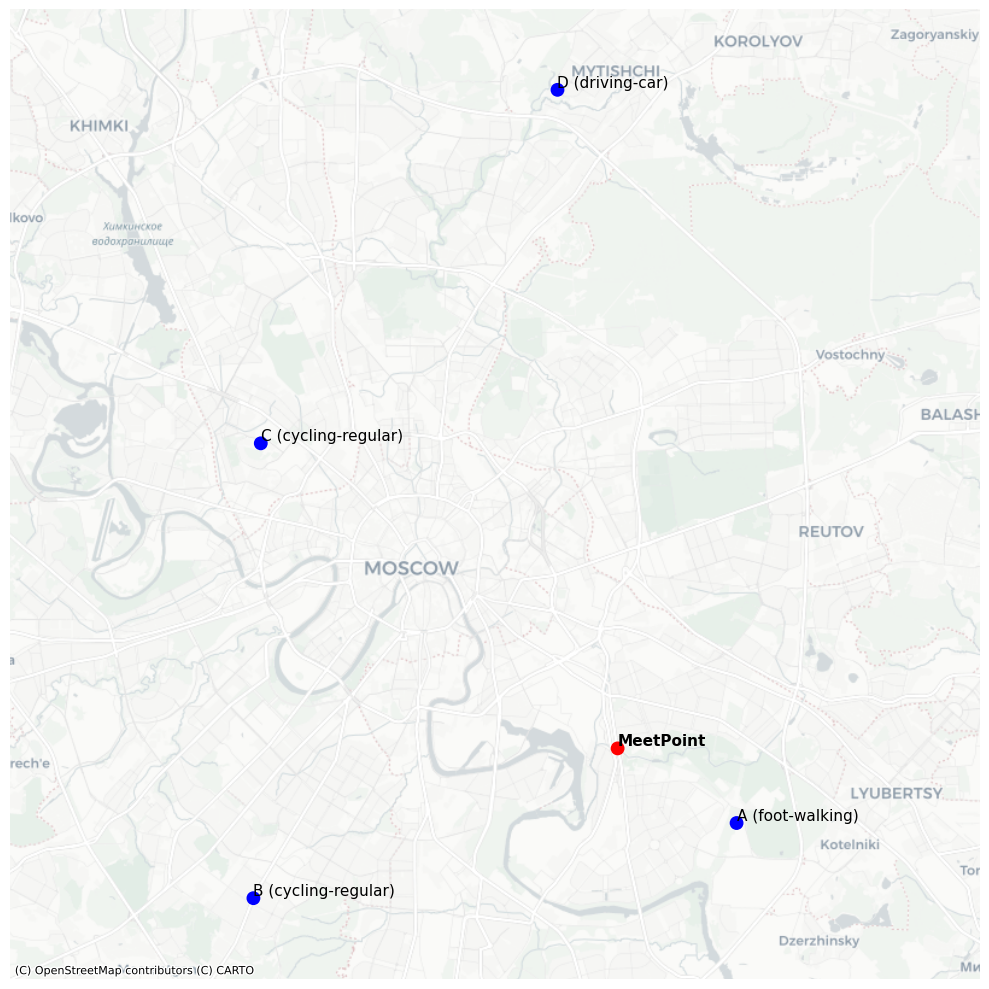

In [ ]:
# Определение минимаксной точки встречи

Оптимальная точка встречи: (55.673533, 37.799902)
Время от каждого человека: от A (foot-walking): 8.0 мин, от B (cycling-regular): 85.0 мин, от C (cycling-regular): 100.9 мин, от D (driving-car): 36.9 мин
Сумма времён: 230.7 мин, Максимальное время для одного человека: 100.9 мин


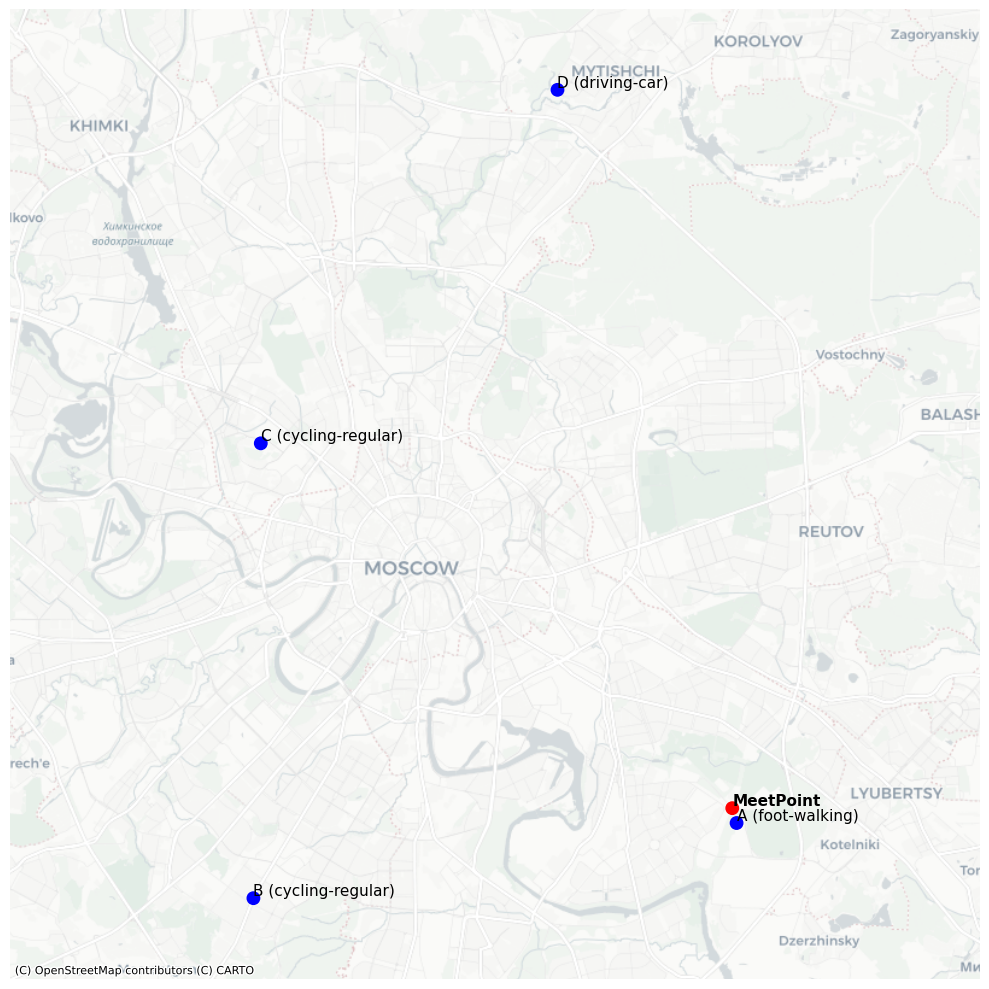

In [3]:
# Определение минисуммной точки встречи с последующей поездкой

Оптимальная точка встречи: (55.693977, 37.734576)
Время от каждого человека: от A (foot-walking): 71.0 мин, от B (cycling-regular): 74.7 мин, от C (cycling-regular): 75.0 мин, от D (driving-car): 38.1 мин
Сумма времён: 258.9 мин, Максимальное время для одного человека: 75.0 мин


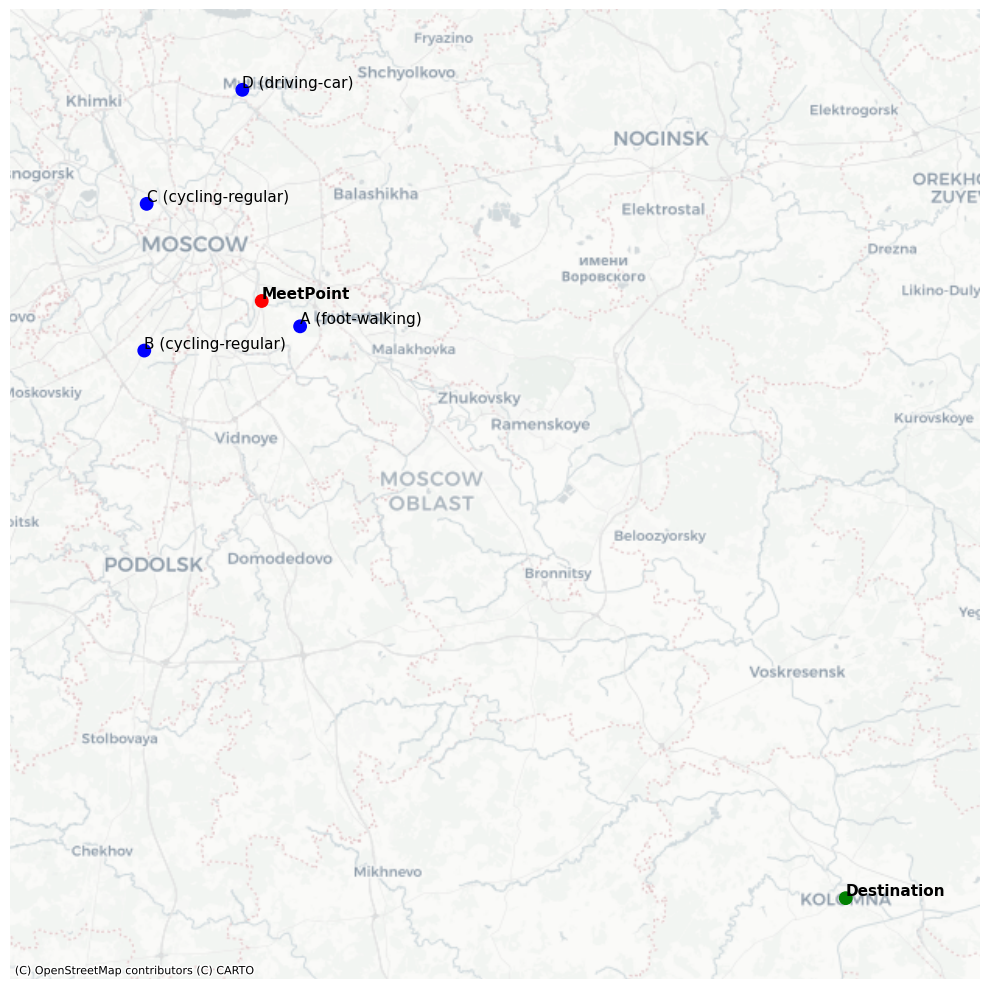

In [ ]:
# Определение минимаксной точки встречи с последующей поездкой

Оптимальная точка встречи: (55.687274, 37.818793)
Время от каждого человека: от A (foot-walking): 34.1 мин, от B (cycling-regular): 95.8 мин, от C (cycling-regular): 97.7 мин, от D (driving-car): 32.8 мин
Сумма времён: 260.5 мин, Максимальное время для одного человека: 97.7 мин


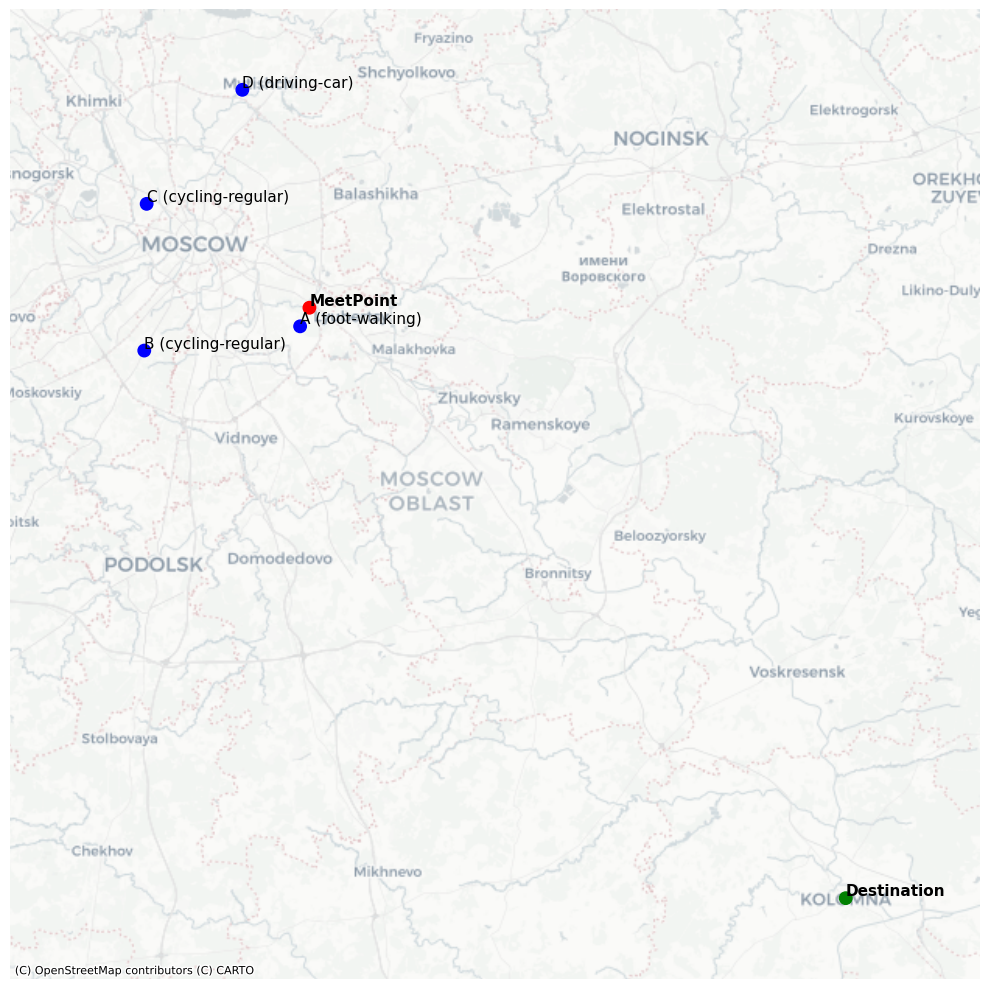

In [ ]:
# Определение минисуммной точки встречи с последующей поездкой